# Quantum signal processing for eigenstate filtering

References:
- John M. Martyn, Zane M. Rossi, Andrew K. Tan, Isaac L. Chuang  
  Grand unification of quantum algorithms  
  [PRX Quantum 2, 040203 (2021)](https://doi.org/10.1103/PRXQuantum.2.040203)
- Lin Lin, Yu Tong  
  Optimal polynomial based quantum eigenstate filtering with application to solving quantum linear systems  
  [Quantum 4, 361 (2020)](https://doi.org/10.22331/q-2020-11-11-361)

In [1]:
import numpy as np
from scipy.linalg import sqrtm, cosm, sinm, expm
import matplotlib.pyplot as plt

In [2]:
import qib

## Quantum signal processing circuit

In [3]:
def S(phi: float, q: qib.field.Qubit):
    """
    Construct the "signal-processing rotation operator".
    """
    return qib.RzGate(-2*phi, q)

In [4]:
def qsp_circuit(V, phi_list, qaux):
    """
    Construct the quantum signal processing (QSP) circuit.
    """
    assert len(phi_list) > 0
    circuit = qib.Circuit()
    circuit.append_gate(S(phi_list[0], qaux))
    for phi in phi_list[1:]:
        circuit.append_gate(V)
        circuit.append_gate(S(phi, qaux))
    return circuit

In [5]:
def W(a: float, q: qib.field.Qubit):
    """
    Construct the "signal rotation operator".
    """
    return qib.RxGate(-2*np.arccos(a), q)

## Construct Hamiltonian and block-encoding gate

In [6]:
# Pauli operator consisting of weighted Pauli strings
H = qib.PauliOperator([
    qib.WeightedPauliString(qib.PauliString.from_string("III"),  2*0.25),
    qib.WeightedPauliString(qib.PauliString.from_string("XZX"), -2*0.04),
    qib.WeightedPauliString(qib.PauliString.from_string("XYY"),  2*0.11),
    qib.WeightedPauliString(qib.PauliString.from_string("ZIY"),  2*0.07),
    qib.WeightedPauliString(qib.PauliString.from_string("XYZ"), -2*0.1),])

In [7]:
latt = qib.lattice.IntegerLattice((3,), pbc=False)
field_pauli = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
H.set_field(field_pauli);

In [8]:
# norm of H must be less or equal to 1
np.linalg.norm(H.as_matrix().toarray(), ord=2)

0.9849691346263316

λ: [0.01503087 0.17503087 0.19196491 0.35196491 0.64803509 0.80803509
 0.82496913 0.98496913]


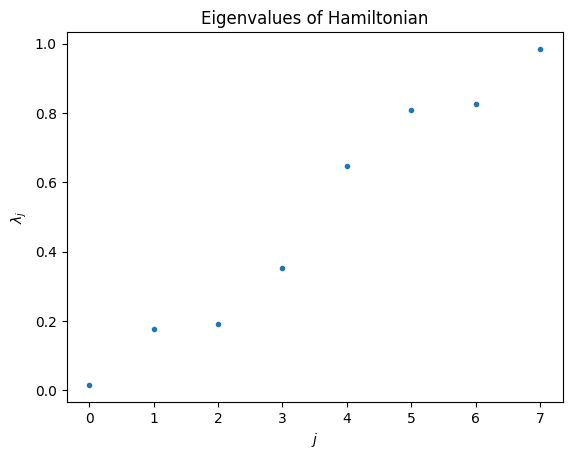

In [9]:
# show spectrum
Hmat = H.as_matrix().toarray()
λ, ψ = np.linalg.eigh(Hmat)
print("λ:", λ)
plt.plot(λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [10]:
# consistency check
np.linalg.norm(Hmat - sum(λ[j]*np.outer(ψ[:, j], ψ[:, j].conj()) for j in range(len(λ))))

2.357126092147354e-15

In [11]:
# auxiliary qubit
field_aux = qib.field.Field(qib.field.ParticleType.QUBIT,
                            qib.lattice.IntegerLattice((1,), pbc=False))
qaux = qib.field.Qubit(field_aux, 0)

In [12]:
# block-encoding gate; plays the role of the signal operator
R = qib.BlockEncodingGate(H, qib.operator.BlockEncodingMethod.R)
R.set_auxiliary_qubits([qaux])
R.num_wires

4

In [13]:
R.encoded_operator() is H

True

## Filtering function and its QSP approximation

In [14]:
def target_filt(x, delta, scale=1):
    """
    Target function for eigenvalue filtering.
    """
    return scale * (np.sign(x + 0.5*delta) - np.sign(x - 0.5*delta)) / 2

In [15]:
# approximating polynomial as computed by pyqsp;
# note: seems to differ slightly from polynomial proposed in paper by Lin Lin and Yu Tong

# import pyqsp
# pg = pyqsp.poly.PolyEigenstateFiltering()
# pcoeffs, scale = pg.generate(30, 0.3, ensure_bounded=True, return_scale=True)
pcoeffs = np.array([
    9.000000000000337e-01,  0.0, -7.031620318208381e+01,  0.0,
    2.1539623152761696e+03, 0.0, -3.5186888660573706e+04, 0.0,
    3.5154605133750144e+05, 0.0, -2.3230789225621773e+06, 0.0,
    1.0663078854882404e+07, 0.0, -3.506929672629646e+07,  0.0,
    8.418284691465965e+07,  0.0, -1.4871920531343466e+08, 0.0,
    1.930761269080084e+08,  0.0, -1.8191063056062633e+08, 0.0,
    1.2096262368079624e+08, 0.0, -5.380345137360861e+07,  0.0,
    1.436188179406601e+07,  0.0, -1.7393389645274098e+06])
poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

30

In [16]:
# corresponding phase angles from Appendix D.8 of "Grand unification of quantum algorithms"
phi_filt = np.array([
    -2.22655153,  2.26982696, -0.76378956,  0.07418111,
     0.25458387,  0.5916072,   0.30309002,  0.10101557,
    -0.12943648, -1.00141425,  0.60368299, -2.2897962,
    -0.04337353,  0.28364185,  2.28161478, -0.61804648,
    -0.85997787,  0.28364185, -0.04337353,  0.85179646,
     0.60368299, -1.00141425, -0.12943648,  0.10101557,
     0.30309002,  0.5916072,   0.25458387,  0.07418111,
    -0.76378956, -0.87176569,  2.48583745])

In [17]:
circ_filt = lambda a: qsp_circuit(W(a, qaux), phi_filt, qaux)

In [18]:
# |+⟩
ketp = np.array([1, 1])/np.sqrt(2)

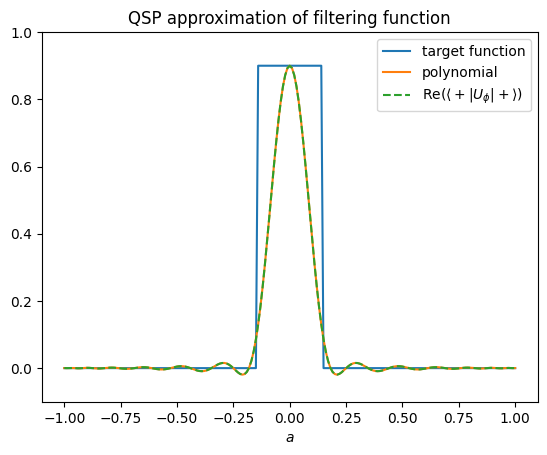

In [19]:
# visualize target function, polynomial approximation and corresponding QSP representation;
# reproduces Fig. 23 in "Grand unification of quantum algorithms"
a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), label="target function")
plt.plot(a_list, poly_filt(a_list), label="polynomial")
plt.plot(a_list, [np.vdot(ketp, circ_filt(a).as_matrix().toarray() @ ketp).real for a in a_list], "--", label=r"$\mathrm{Re}(\langle+|U_{\phi}|+\rangle)$")
plt.ylim([-0.1, 1])
plt.xlabel(r"$a$")
plt.legend()
plt.title("QSP approximation of filtering function")
plt.show()

In [20]:
# QSP polynomial approximation error
np.linalg.norm(np.array([np.vdot(ketp, circ_filt(a).as_matrix().toarray() @ ketp).real for a in a_list]) - poly_filt(a_list), np.inf)

0.00013479245741976337

In [21]:
# spurious imaginary part in QSP
max([abs(np.vdot(ketp, circ_filt(a).as_matrix().toarray() @ ketp).imag) for a in a_list])

1.0605709348817603e-08

## Apply eigenstate filtering to Hamiltonian

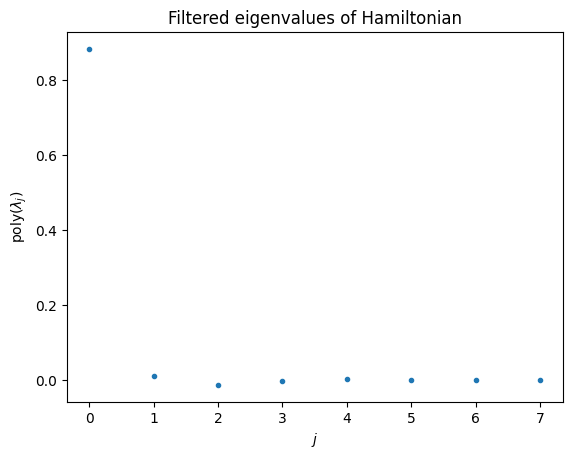

In [22]:
# visualize filtered eigenvalues
plt.plot(poly_filt(λ), ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\mathrm{poly}(\lambda_j)$")
plt.title("Filtered eigenvalues of Hamiltonian")
plt.show()

In [23]:
def convert_phase_shifts(d):
    """
    Phase shifts to convert between different QSP representations.
    """
    return np.array([np.pi/4] + (d-1)*[np.pi/2] + [np.pi/4])

In [24]:
# construct quantum circuit
circ_hamil_filt = qsp_circuit(R, phi_filt - convert_phase_shifts(len(phi_filt) - 1), qaux)

# include global i**d phase factor
circ_hamil_filt.append_gate(qib.PhaseFactorGate(0.5*np.pi * ((len(phi_filt)-1) % 4), 1).on(qaux))

# appending and prepending Hadamard gates, corresponds to convention <+|U_φ|+>
circ_hamil_filt.append_gate( qib.HadamardGate(qaux))
circ_hamil_filt.prepend_gate(qib.HadamardGate(qaux))

In [25]:
# matrix representation of circuit
U_filt = circ_hamil_filt.as_matrix([field_pauli, field_aux]).toarray()

In [26]:
# consistency check (should be numerically zero)
np.linalg.norm(U_filt[:8, :8] - sum(np.vdot(ketp, circ_filt(λ[j]).as_matrix().toarray() @ ketp) * np.outer(ψ[:, j], ψ[:, j].conj()) for j in range(len(λ))))

3.3341852995103415e-14

In [27]:
def symm(a):
    """
    Symmetrize a matrix by projecting it onto the symmetric subspace.
    """
    return 0.5 * (a + a.conj().T)

In [28]:
# consistency check (should be numerically zero)
np.linalg.norm(symm(U_filt[:8, :8]) - sum(circ_filt(λ[j]).as_matrix().toarray()[0, 0].real * np.outer(ψ[:, j], ψ[:, j].conj()) for j in range(len(λ))))

3.320609956590346e-14

In [29]:
# additional error due to spurious imaginary part in QSP
np.linalg.norm(U_filt[:8, :8] - sum(circ_filt(λ[j]).as_matrix().toarray()[0, 0].real * np.outer(ψ[:, j], ψ[:, j].conj()) for j in range(len(λ))))

1.1420352261438788e-08

In [30]:
# filtering function applied to Hamiltonian: poly_filt(H)
H_poly = sum(poly_filt(λ[j]) * np.outer(ψ[:, j], ψ[:, j].conj()) for j in range(len(λ)))

In [31]:
# QSP approximation error of poly_filt(H)
np.linalg.norm(U_filt[:8, :8] - H_poly, ord=2)

9.166973425850837e-05

In [32]:
# probability of collapsing to upper-left block when starting from initial state |0,...,0> 
ψ0filt = U_filt[:8, 0]
np.linalg.norm(ψ0filt)**2

0.04467759043706545

In [33]:
# overlap with ground state (after normalization)
abs(np.vdot(ψ0filt / np.linalg.norm(ψ0filt), ψ[:, 0]))

0.9994643174179724